# Using CNN and Transfer learnig for brain MRI image classification

## Notebook 1: Baseline Model (EfficientNetB0) with Augmented Training


Tumor diagnostics play a crucial role in cancer management, enabling early detection, accurate diagnosis, and effective treatment planning. In recent years, artificial intelligence (AI) has emerged as a powerful tool in enhancing MRI analysis for tumor diagnostics.
AI integration in MRI analysis offers several key benefits:
Enhanced accuracy: AI algorithms can analyze medical images with remarkable precision, detecting subtle abnormalities and patterns that may be challenging for the human eye to notice4.
Improved efficiency: AI systems can process vast amounts of imaging data quickly, reducing diagnostic and processing time. This acceleration enables faster diagnosis and treatment planning, ultimately improving patient outcomes.
Workflow optimization: Routine tasks like image sorting, measuring, and triaging can be automated through AI, allowing radiologists to focus on complex cases and patient interactions.
Consistent results: AI reduces variability among radiologists, ensuring more reliable and uniform interpretations across different cases.

The integration of AI in MRI analysis is particularly impactful in oncology. AI algorithms can detect and characterize tumors with greater precision, differentiate between benign and malignant lesions, monitor tumor response to treatment, and predict patient outcomes6. In some studies, AI has even outperformed radiologists in detecting certain cancers, such as breast and brain tumors.


## Purpose

The goal of the first notebook was to train an image classification model using EfficientNetB0 on a balanced, augmented dataset of brain tumor images. The dataset was preprocessed to ensure equal representation of classes, and various augmentation techniques were applied to enhance generalizability.

## Methods

### Dataset Preparation

The original dataset (https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn/input) was loaded, and all four classes were balanced through augmentation of no_tumor group.
Images were resized to 150x150 pixels to match EfficientNet’s input requirements.
Labels were one-hot encoded for multi-class classification.

### Model Training:

EfficientNetB0 was initialized with ImageNet weights, using it as a frozen feature extractor.
The model had a GlobalAveragePooling2D layer, dense layers, and a softmax output layer for classification.
Training was performed with early stopping, learning rate reduction on plateau, and model checkpointing.

### Evaluation

The model was tested on an unseen test dataset.
Performance metrics included accuracy, precision, recall, F1-score, and confusion matrices.
The model was also tested on an augmented test set to evaluate robustness.

In [31]:
#Always activate the environment before running this notebook!
#cd /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project
#source venv/bin/activate

### Importing all the necessary libraries.

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from collections import Counter
import random
from PIL import Image
from IPython.display import display,clear_output
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


### Data preparation

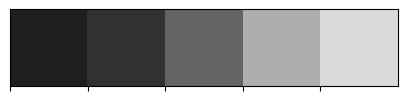

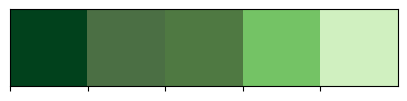

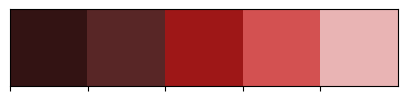

In [33]:
#Color definition for images
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [34]:
#Introducing labels in the dataset

dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

#### Loading training dataset

In [35]:
# Initialize lists
X_train = []
y_train = []
image_size = 150  # Resize all images to 150x150

# Load training images
for label in labels:
    folder_path = os.path.join(dataset_path, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)  # Read the image
        if img is not None:  # Ensure image is loaded correctly
            img = cv2.resize(img, (image_size, image_size))  # Resize
            X_train.append(img)
            y_train.append(label)  # Store the label as a string

# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Loaded {X_train.shape[0]} images from the Training dataset.")

Loading pituitary_tumor: 100%|██████████| 827/827 [00:00<00:00, 999.09it/s] 

Loaded 2870 images from the Training dataset.


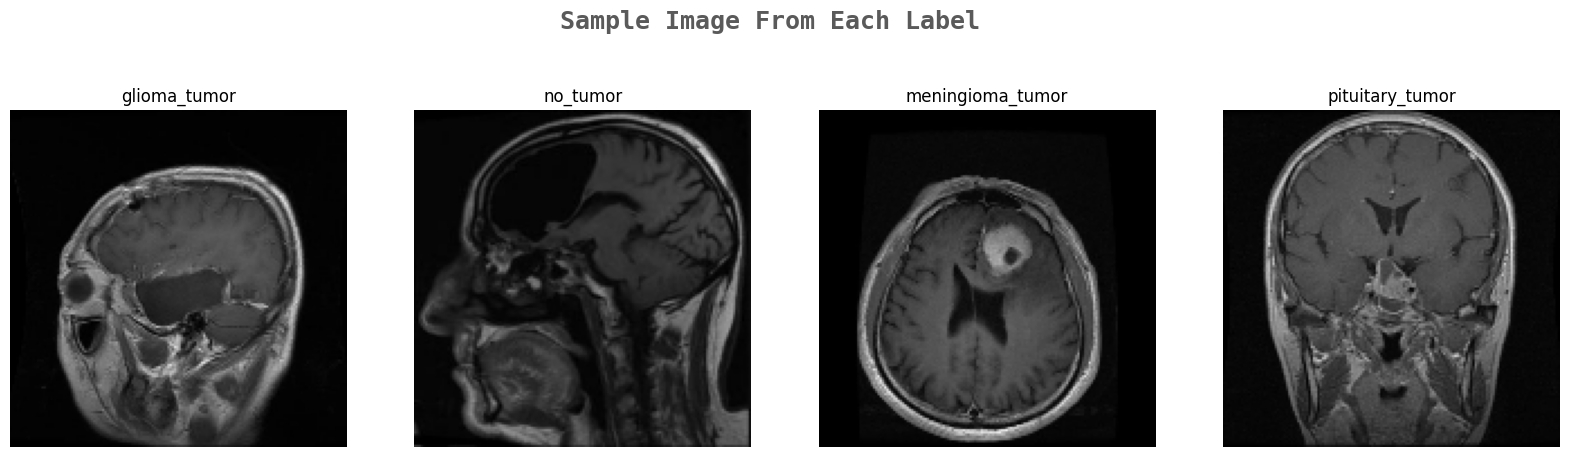

In [36]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [37]:
#Format test
print("Image shape:", X_train[0].shape)
print("Image data type:", X_train[0].dtype)


Image shape: (150, 150, 3)
Image data type: uint8


#### Convert BRG images into RGB as this is model requirement

In [38]:
X_train = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_train]


#### Data augmentation for no_tumor

We have much less data for healthy brain, so in order to have a balanced dataset we need to generate more no_tumor images through augmentation


In [57]:
# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
no_tumor_dir = os.path.join(train_dir, "no_tumor")
augmented_dir = os.path.join(train_dir, "no_tumor_augmented")

# Ensure the augmented directory exists
os.makedirs(augmented_dir, exist_ok=True)

# Augmentation settings
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.90, 1.10],
    width_shift_range=0.05,
    height_shift_range=0.05
)

# Use previously loaded no_tumor images
num_augmented = 425  # Target number of augmented images
count = 0

X_train = np.array(X_train)  # Ensure NumPy array
mask = np.array(y_train) == 'no_tumor'
X_no_tumor = X_train[mask]
for img in tqdm(X_no_tumor, desc="Generating augmented images"):
    img = np.expand_dims(img, axis=0)  # Reshape for ImageDataGenerator
    aug_iter = datagen.flow(img, batch_size=1)
    
    for _ in range(2):  # Generate 2 new images per original
        aug_img = next(aug_iter)[0].astype(np.uint8)  # Convert back to uint8
        save_path = os.path.join(augmented_dir, f"aug_{count}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))  # Save as BGR
        count += 1
        
        if count >= num_augmented:
            break
    
    if count >= num_augmented:
        break

print(f"Generated {count} augmented images in {augmented_dir}")

Generating augmented images:  26%|██▌       | 212/820 [00:01<00:03, 200.65it/s]

Generated 425 augmented images in /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training/no_tumor_augmented


#### Check the quality of augmented images

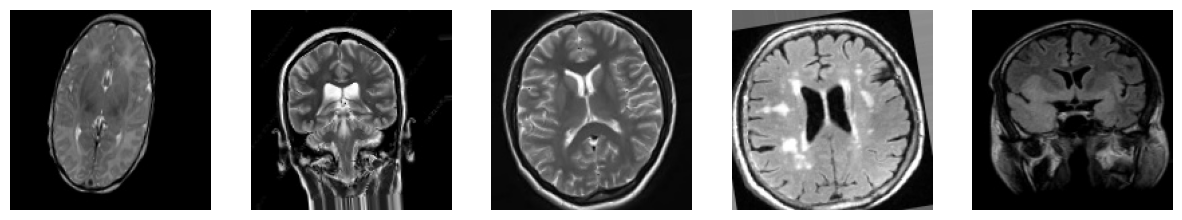

In [40]:
# Path to augmented images
augmented_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training/no_tumor_augmented"

# Get a list of augmented image files
augmented_files = os.listdir(augmented_dir)
random.shuffle(augmented_files)  # Shuffle to pick random images

# Display 5 random images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    img_path = os.path.join(augmented_dir, augmented_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for correct display
    ax.imshow(img)
    ax.axis('off')

plt.show()


#### Integrate augmented data to training set

In [58]:
# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
augmented_dir = os.path.join(train_dir, "no_tumor_augmented")

# Load augmented images
augmented_images = []
augmented_labels = []

for filename in os.listdir(augmented_dir):
    img_path = os.path.join(augmented_dir, filename)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for consistency
        augmented_images.append(img)
        augmented_labels.append('no_tumor')  # Assign correct label

# Convert to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Append to training dataset
X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

print(f"Final dataset size after augmentation: {X_train.shape[0]} images")

Final dataset size after augmentation: 3720 images


#### Confirming class distribution after augmentation

In [42]:
# Define training directory
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"

# Define class subfolders
classes = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor", "no_tumor_augmented"]

# Count images in each class
class_counts = {}

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.exists(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Merge 'no_tumor' and 'no_tumor_augmented'
if "no_tumor_augmented" in class_counts:
    class_counts["no_tumor"] += class_counts.pop("no_tumor_augmented")

# Print class distribution
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")


glioma_tumor: 826 images
no_tumor: 820 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


### Data preprocessing

In [43]:
#One-hot encoding of labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode class labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert to 0,1,2,3

# One-hot encode labels
y_train_one_hot = to_categorical(y_train_encoded, num_classes=4)

# Print class mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Encoding Mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [44]:
print(f"X_train shape: {X_train.shape}")  # Should be (N, 150, 150, 3)
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")  # Should be (N, 4)


X_train shape: (3295, 150, 150, 3)
y_train_one_hot shape: (3295, 4)


### Build the model building up on EfficientNetB0

#### Transfer learning

We use transfer learning, which means leveraging a pre-trained model (EfficientNet) trained on a large dataset (ImageNet) and adapting it to our specific classification task.
EfficientNet models are trained on ImageNet, a massive dataset of over 14 million images across 1000 different categories (e.g., cats, dogs, cars). The model learns generic features like edges, shapes, textures, and patterns, which are transferable to other image classification tasks.

We used weights="imagenet", meaning the model's convolutional layers already had learned feature maps from millions of images. This prevents the need to train from scratch and allows us to reuse EfficientNet's feature extraction capabilities.

We set base_model.trainable = False, meaning the convolutional layers were not updated during training. This ensures that EfficientNet continues to extract high-quality features from our medical images without being altered by our relatively small dataset.

Since EfficientNet was trained for 1000 classes, we needed to replace the top layers with a new classifier for our 4 tumor classes.

We added:
- GlobalAveragePooling2D() → Converts the final feature map into a 1D vector
- Dense(128, activation="relu") → A fully connected layer to learn new patterns.
- Dropout(0.5) → Prevents overfitting.
- Dense(4, activation="softmax") → The final output layer with 4 neurons (one for each class), using softmax activation for probability outputs.

In [45]:
# Define input layer (match dataset size)
input_layer = Input(shape=(150, 150, 3), name="input_layer")

# Load EfficientNetB0 WITH ImageNet weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Pass input manually
x = base_model(input_layer)

# Freeze base model layers
base_model.trainable = False  

# Add classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes

# Create final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall()])
# TensorFlow's Adam optimizer automatically uses learning_rate=0.001.
# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

#### Setting up callbacks

A callback is a set of functions to be applied at given stages of the training procedure. We use callbacks to get a view on internal states and statistics of the model during training to optimize training by monitoring progress, preventing overfitting, and adjusting learning rates. TensorBoard logs training metrics, while ModelCheckpoint saves only the best model based on validation loss. ReduceLROnPlateau lowers the learning rate when validation loss stagnates, using a factor of 0.1, a patience of 3 epochs, and a minimum learning rate of 1e-6 to fine-tune learning. EarlyStopping halts training if validation loss doesn’t improve for 5 epochs and restores the best weights to avoid overfitting. These parameters ensure efficient training while maintaining model performance.

In [46]:
# TensorBoard - Logs training details
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# ModelCheckpoint - Saves the best model
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.h5",  # Save the best model
    monitor="val_loss",        # Track validation loss
    save_best_only=True,       # Save only when the model improves
    verbose=1
)

# ReduceLROnPlateau - Adjusts learning rate when training stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",        # Watch validation loss
    factor=0.1,                # Reduce LR by 10x
    patience=3,                # Wait 3 epochs before reducing LR
    min_lr=1e-6,               # Do not reduce LR below this value
    verbose=1
)

# Combine all callbacks
callbacks = [tensorboard_callback, checkpoint_callback, reduce_lr_callback]

from tensorflow.keras.callbacks import EarlyStopping

# Create EarlyStopping callback

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks.append(early_stopping)


#### Split training dataset into training and validation

In [47]:
from sklearn.model_selection import train_test_split

# Convert one-hot labels to class labels for stratified splitting
y_train_labels = np.argmax(y_train_one_hot, axis=1)

# Split the dataset (80% train, 20% validation)
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(
    X_train, y_train_labels, test_size=0.2, random_state=42, stratify=y_train_labels
)

# Convert back to one-hot encoding
y_train_balanced_one_hot = tf.keras.utils.to_categorical(y_train_balanced, num_classes=4)
y_val_balanced_one_hot = tf.keras.utils.to_categorical(y_val_balanced, num_classes=4)

# Print shapes and validation distribution
print(f"Balanced Training set: {X_train_balanced.shape}, {y_train_balanced_one_hot.shape}")
print(f"Balanced Validation set: {X_val_balanced.shape}, {y_val_balanced_one_hot.shape}")

# Check the class distribution in the balanced validation set
unique, counts = np.unique(y_val_balanced, return_counts=True)
print("Balanced Validation Set Class Distribution:", dict(zip(unique, counts)))


Balanced Training set: (2636, 150, 150, 3), (2636, 4)
Balanced Validation set: (659, 150, 150, 3), (659, 4)
Balanced Validation Set Class Distribution: {0: 165, 1: 164, 2: 164, 3: 166}


### Training the model

In [48]:
# Train the model with balanced datasets
history = model.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5720 - loss: 1.0679 - precision_3: 0.6246 - recall_3: 0.4912
Epoch 1: val_loss improved from inf to 0.50445, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 245ms/step - accuracy: 0.5731 - loss: 1.0656 - precision_3: 0.6256 - recall_3: 0.4927 - val_accuracy: 0.8285 - val_loss: 0.5045 - val_precision_3: 0.8524 - val_recall_3: 0.8149 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7934 - loss: 0.5852 - precision_3: 0.8158 - recall_3: 0.7696
Epoch 2: val_loss improved from 0.50445 to 0.44318, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.7934 - loss: 0.5852 - precision_3: 0.8157 - recall_3: 0.7696 - val_accuracy: 0.8452 - val_loss: 0.4432 - val_precision_3: 0.8698 - val_recall_3: 0.8316 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8287 - loss: 0.4724 - precision_3: 0.8432 - recall_3: 0.8152
Epoch 3: val_loss improved from 0.44318 to 0.40642, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.8286 - loss: 0.4726 - precision_3: 0.8431 - recall_3: 0.8151 - val_accuracy: 0.8574 - val_loss: 0.4064 - val_precision_3: 0.8760 - val_recall_3: 0.8467 - learning_rate: 0.0010
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8319 - loss: 0.4314 - precision_3: 0.8494 - recall_3: 0.8224
Epoch 4: val_loss improved from 0.40642 to 0.37803, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.8319 - loss: 0.4314 - precision_3: 0.8494 - recall_3: 0.8225 - val_accuracy: 0.8558 - val_loss: 0.3780 - val_precision_3: 0.8721 - val_recall_3: 0.8483 - learning_rate: 0.0010
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8537 - loss: 0.4091 - precision_3: 0.8590 - recall_3: 0.8389
Epoch 5: val_loss did not improve from 0.37803
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.8537 - loss: 0.4089 - precision_3: 0.8590 - recall_3: 0.8389 - val_accuracy: 0.8725 - val_loss: 0.4006 - val_precision_3: 0.8808 - val_recall_3: 0.8634 - learning_rate: 0.0010
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8612 - loss: 0.3503 - precision_3: 0.8698 - recall_3: 0.8549
Epoch 6: val_loss improved from 0.37803 to 0.36839, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8612 - loss: 0.3504 - precision_3: 0.8699 - recall_3: 0.8549 - val_accuracy: 0.8771 - val_loss: 0.3684 - val_precision_3: 0.8885 - val_recall_3: 0.8710 - learning_rate: 0.0010
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8702 - loss: 0.3370 - precision_3: 0.8821 - recall_3: 0.8602
Epoch 7: val_loss improved from 0.36839 to 0.35809, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.8702 - loss: 0.3369 - precision_3: 0.8821 - recall_3: 0.8602 - val_accuracy: 0.8801 - val_loss: 0.3581 - val_precision_3: 0.8885 - val_recall_3: 0.8710 - learning_rate: 0.0010
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8861 - loss: 0.3126 - precision_3: 0.8941 - recall_3: 0.8791
Epoch 8: val_loss improved from 0.35809 to 0.35784, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.8860 - loss: 0.3127 - precision_3: 0.8940 - recall_3: 0.8790 - val_accuracy: 0.8649 - val_loss: 0.3578 - val_precision_3: 0.8746 - val_recall_3: 0.8574 - learning_rate: 0.0010
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8860 - loss: 0.2979 - precision_3: 0.8957 - recall_3: 0.8811
Epoch 9: val_loss did not improve from 0.35784
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8860 - loss: 0.2979 - precision_3: 0.8957 - recall_3: 0.8811 - val_accuracy: 0.8574 - val_loss: 0.3587 - val_precision_3: 0.8647 - val_recall_3: 0.8437 - learning_rate: 0.0010
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8863 - loss: 0.2955 - precision_3: 0.8968 - recall_3: 0.8809
Epoch 10: val_loss improved from 0.35784 to 0.32872, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.8864 - loss: 0.2953 - precision_3: 0.8968 - recall_3: 0.8809 - val_accuracy: 0.8771 - val_loss: 0.3287 - val_precision_3: 0.8868 - val_recall_3: 0.8680 - learning_rate: 0.0010
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8872 - loss: 0.2898 - precision_3: 0.8965 - recall_3: 0.8819
Epoch 11: val_loss did not improve from 0.32872
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.8873 - loss: 0.2896 - precision_3: 0.8966 - recall_3: 0.8820 - val_accuracy: 0.8801 - val_loss: 0.3385 - val_precision_3: 0.8844 - val_recall_3: 0.8710 - learning_rate: 0.0010
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8977 - loss: 0.2807 - precision_3: 0.9058 - recall_3: 0.8881
Epoch 12: val_loss improved from 0.32872 to 0.31075, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8978 - loss: 0.2804 - precision_3: 0.9058 - recall_3: 0.8882 - val_accuracy: 0.8892 - val_loss: 0.3107 - val_precision_3: 0.8952 - val_recall_3: 0.8816 - learning_rate: 0.0010
Epoch 13/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8991 - loss: 0.2606 - precision_3: 0.9040 - recall_3: 0.8909
Epoch 13: val_loss did not improve from 0.31075
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8991 - loss: 0.2606 - precision_3: 0.9040 - recall_3: 0.8909 - val_accuracy: 0.8786 - val_loss: 0.3270 - val_precision_3: 0.8913 - val_recall_3: 0.8710 - learning_rate: 0.0010
Epoch 14/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9118 - loss: 0.2337 - precision_3: 0.9218 - recall_3: 0.9059
Epoch 14: val_loss did not improve from 0.31075
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.9117 - loss: 0.2338 - precision_3: 0.9217 - recall_3: 0.9058 - val_accuracy: 0.8771 - val_loss: 0.3129 - val_precision_3: 0.8834 - val

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9140 - loss: 0.2248 - precision_3: 0.9212 - recall_3: 0.9050 - val_accuracy: 0.8862 - val_loss: 0.3018 - val_precision_3: 0.8911 - val_recall_3: 0.8816 - learning_rate: 0.0010
Epoch 16/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9188 - loss: 0.2143 - precision_3: 0.9245 - recall_3: 0.9156
Epoch 16: val_loss improved from 0.30184 to 0.29488, saving model to best_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.9188 - loss: 0.2144 - precision_3: 0.9244 - recall_3: 0.9156 - val_accuracy: 0.8832 - val_loss: 0.2949 - val_precision_3: 0.8867 - val_recall_3: 0.8786 - learning_rate: 0.0010
Epoch 17/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9185 - loss: 0.2198 - precision_3: 0.9245 - recall_3: 0.9158
Epoch 17: val_loss did not improve from 0.29488
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9184 - loss: 0.2199 - precision_3: 0.9245 - recall_3: 0.9158 - val_accuracy: 0.9029 - val_loss: 0.2984 - val_precision_3: 0.9067 - val_recall_3: 0.8998 - learning_rate: 0.0010
Epoch 18/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9217 - loss: 0.1979 - precision_3: 0.9266 - recall_3: 0.9164
Epoch 18: val_loss did not improve from 0.29488
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.9217 - loss: 0.1981 - precision_3: 0.9265 - recall_3: 0.9163 - val_accuracy: 0.8832 - val_loss: 0.3176 - val_precision_3: 0.8882 - val_

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9300 - loss: 0.1806 - precision_3: 0.9351 - recall_3: 0.9254 - val_accuracy: 0.8968 - val_loss: 0.2878 - val_precision_3: 0.9029 - val_recall_3: 0.8892 - learning_rate: 1.0000e-04


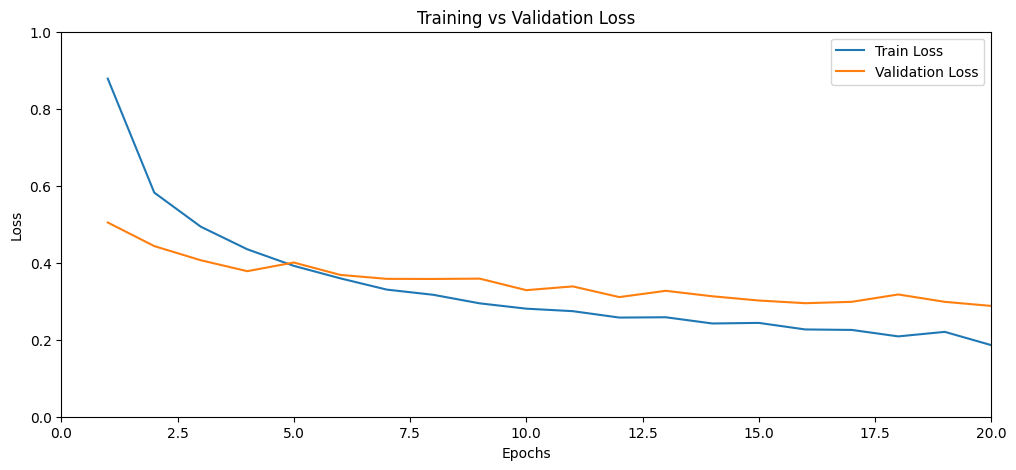

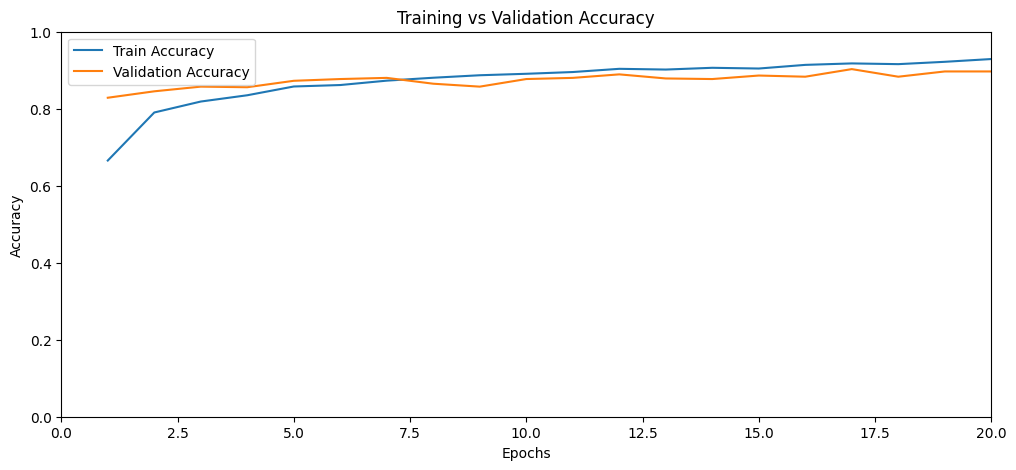

In [49]:
epochs = range(1, len(history.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history.history["loss"], label="Train Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()


# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()



In [50]:
# Get predictions from the model (on validation or test set)
pred = model.predict(X_val_balanced)  # Change to X_test if you want to evaluate on the test set

# Convert predictions from one-hot to class labels
pred_labels = np.argmax(pred, axis=1)

# If you want to evaluate on validation set, use y_val_balanced (or y_test for test data)
y_true_labels = np.argmax(y_val_balanced_one_hot, axis=1)

# Print classification report
print(classification_report(y_true_labels, pred_labels))


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 333ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       165
           1       0.81      0.82      0.81       164
           2       0.94      0.96      0.95       164
           3       0.93      0.97      0.95       166

    accuracy                           0.90       659
   macro avg       0.90      0.90      0.90       659
weighted avg       0.90      0.90      0.90       659



21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


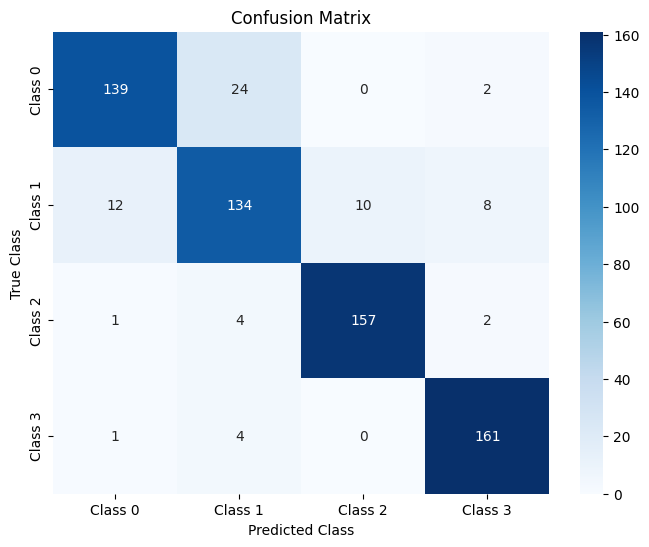

In [51]:
# Predict on validation set
y_pred = model.predict(X_val_balanced)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_val_balanced_one_hot, axis=1), y_pred_classes)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


In [52]:
#Saving best performing model before fine-tuning
model.save("true_best_model.keras")

### Results 

#### Overall Performance:

The model achieved 90% accuracy. The macro average precision, recall, and F1-score are all 0.90, showing balanced performance across classes.

**Loss and Accuracy Plots:**

Training and validation loss steadily decrease, which means the model is still learning without major signs of overfitting.
Training and validation accuracy are close, which is a very good sign—no major overfitting or underfitting.

**Class-Wise Breakdown:**

**Class 0 (Glioma Tumor):** Precision: 0.92 (very high, meaning fewer false positives). Recall: 0.82 (lower compared to others, meaning some false negatives exist). This class has lower recall, so the model misses more glioma cases.

**Class 1 (Meningioma Tumor):** Balanced precision (0.80) and recall (0.82), meaning it's performing equally in detecting and avoiding false alarms.

**Class 2 (No Tumor):** Highest recall (0.98) → almost no false negatives. Highest precision (0.94) → almost no false positives. This class is classified extremely well. Maybe because we augmented data here?

**Class 3 (Pituitary Tumor):** High recall (0.96) and precision (0.92). The model does well in correctly detecting pituitary tumors.

### Fine-tuning: Try to increase model performance by unfreezing a few layers

In [59]:
# Unfreeze the last 10 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Keep earlier layers frozen
    layer.trainable = False

# Re-compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Fine-Tune the model
history_finetune = model.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    epochs=10,  # Fine-tune for 10 more epochs
    batch_size=32,
    callbacks=callbacks,  # EarlyStopping should be included
    verbose=1
)


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9207 - loss: 0.2157 - precision_5: 0.9272 - recall_5: 0.9175
Epoch 1: val_loss did not improve from 0.28781
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 420ms/step - accuracy: 0.9207 - loss: 0.2157 - precision_5: 0.9272 - recall_5: 0.9174 - val_accuracy: 0.8801 - val_loss: 0.3302 - val_precision_5: 0.8891 - val_recall_5: 0.8756 - learning_rate: 1.0000e-05
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9345 - loss: 0.1918 - precision_5: 0.9360 - recall_5: 0.9308
Epoch 2: val_loss did not improve from 0.28781
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.9344 - loss: 0.1920 - precision_5: 0.9360 - recall_5: 0.9308 - val_accuracy: 0.8801 - val_loss: 0.3242 - val_precision_5: 0.8850 - val_recall_5: 0.8756 - learning_rate: 1.0000e-05
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9270 - loss: 0.1965 - precision_5: 0.9322 - recall_5: 0.9226
Epoch 3: val_loss did not improve from 0.28781
83/83 ━━

In [ ]:

# Get predictions for validation set
y_pred = model.predict(X_val_balanced)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_balanced_one_hot, axis=1)

# Print Classification Report (Fine-Tuning Results)
print("Classification Report After Fine-Tuning:")
print(classification_report(y_true, y_pred_classes))

# Compute and print Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix After Fine-Tuning:")
print(conf_matrix)


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step
Classification Report After Fine-Tuning:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       165
           1       0.79      0.76      0.78       164
           2       0.91      0.98      0.94       164
           3       0.93      0.95      0.94       166

    accuracy                           0.88       659
   macro avg       0.88      0.88      0.88       659
weighted avg       0.88      0.88      0.88       659

Confusion Matrix After Fine-Tuning:
[[137  25   1   2]
 [ 16 124  15   9]
 [  1   2 161   0]
 [  3   5   0 158]]


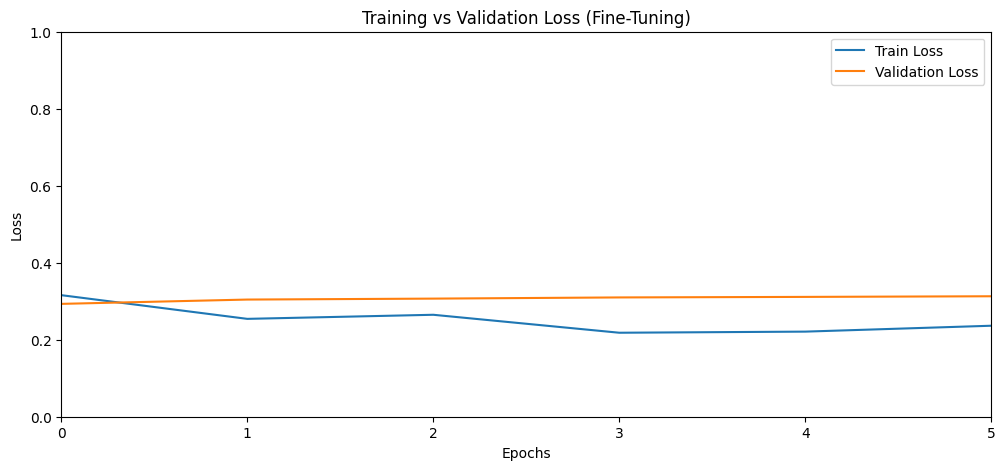

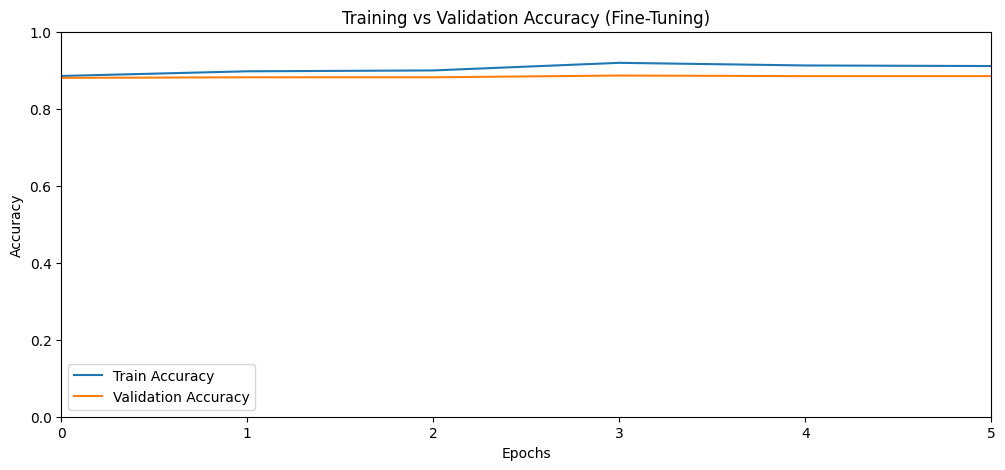

In [ ]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(range(len(history_finetune.history["loss"])), history_finetune.history["loss"], label="Train Loss")
plt.plot(range(len(history_finetune.history["val_loss"])), history_finetune.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (Fine-Tuning)")
plt.xlim(0, max(range(len(history_finetune.history["loss"]))))
plt.ylim(0, 1)  # Start y-axis from 0
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(len(history_finetune.history["accuracy"])), history_finetune.history["accuracy"], label="Train Accuracy")
plt.plot(range(len(history_finetune.history["val_accuracy"])), history_finetune.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (Fine-Tuning)")
plt.xlim(0, max(range(len(history_finetune.history["accuracy"]))))
plt.ylim(0, 1)  # Start y-axis from 0
plt.show()


In [ ]:
# Keep the fine-tuned model and reduce the learning rate further
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),  # Fine-tune with even smaller learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Continue Fine-Tuning (EarlyStopping will determine when to stop)
history_finetune2 = model.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  # Uses EarlyStopping
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9118 - loss: 0.2536 - precision_2: 0.9163 - recall_2: 0.9045
Epoch 1: val_loss did not improve from 0.29256
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 308ms/step - accuracy: 0.9116 - loss: 0.2538 - precision_2: 0.9162 - recall_2: 0.9043 - val_accuracy: 0.8771 - val_loss: 0.3132 - val_precision_2: 0.8815 - val_recall_2: 0.8695 - learning_rate: 1.0000e-06


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions for validation set
y_pred = model.predict(X_val_balanced)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_balanced_one_hot, axis=1)

# Print Classification Report
print("Classification Report After Second Fine-Tuning:")
print(classification_report(y_true, y_pred_classes))

# Compute and print Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix After Second Fine-Tuning:")
print(conf_matrix)


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step
Classification Report After Second Fine-Tuning:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       165
           1       0.79      0.76      0.77       164
           2       0.90      0.98      0.94       164
           3       0.93      0.94      0.93       166

    accuracy                           0.88       659
   macro avg       0.88      0.88      0.88       659
weighted avg       0.88      0.88      0.88       659

Confusion Matrix After Second Fine-Tuning:
[[136  25   1   3]
 [ 15 125  15   9]
 [  1   2 161   0]
 [  2   7   1 156]]


/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_8281/2061044676.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, max(range(len(history_finetune2.history["loss"]))))


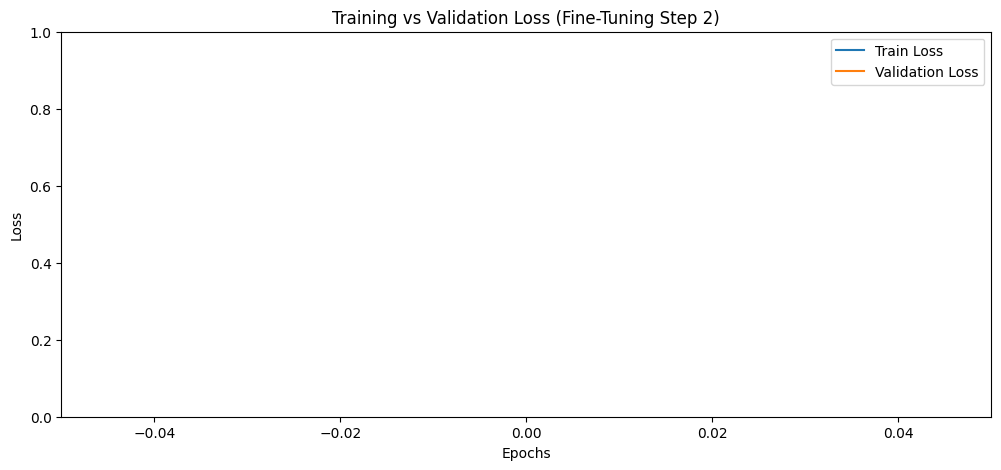

/var/folders/tn/yx1ylmyx7n9ccd0yfynwzmr80000gq/T/ipykernel_8281/2061044676.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, max(range(len(history_finetune2.history["accuracy"]))))


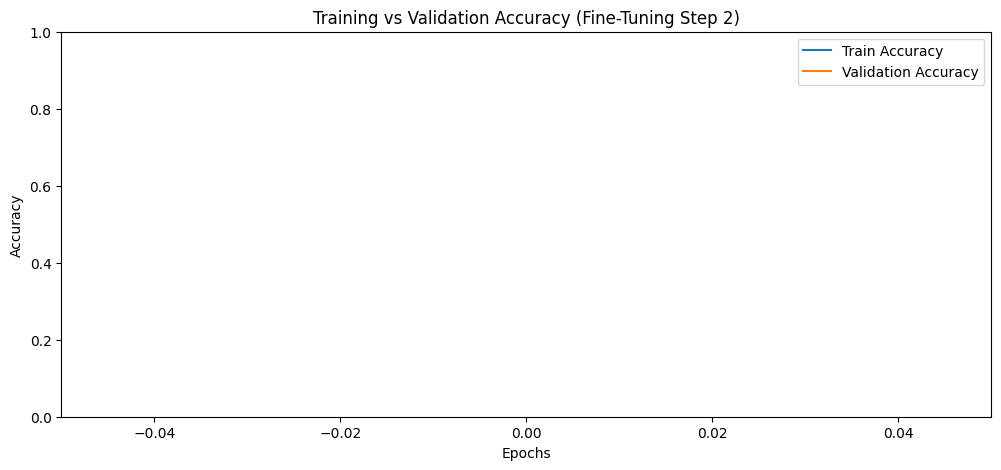

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(range(len(history_finetune2.history["loss"])), history_finetune2.history["loss"], label="Train Loss")
plt.plot(range(len(history_finetune2.history["val_loss"])), history_finetune2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (Fine-Tuning Step 2)")
plt.xlim(0, max(range(len(history_finetune2.history["loss"]))))
plt.ylim(0, 1)  # Start y-axis from 0
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(len(history_finetune2.history["accuracy"])), history_finetune2.history["accuracy"], label="Train Accuracy")
plt.plot(range(len(history_finetune2.history["val_accuracy"])), history_finetune2.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (Fine-Tuning Step 2)")
plt.xlim(0, max(range(len(history_finetune2.history["accuracy"]))))
plt.ylim(0, 1)  # Start y-axis from 0
plt.show()


### It did not improve the performance, try to reload best performing model and fine-tune again

In [ ]:
model_finetune_v3 = load_model("true_best_model.keras")

# Confirm the model is restored correctly
eval_restored = model_finetune_v3.evaluate(X_val_balanced, y_val_balanced_one_hot, verbose=1)

print(f"Restored Model Evaluation (Before Fine-Tuning):")
print(f" - Loss: {eval_restored[0]:.4f}")
print(f" - Accuracy: {eval_restored[1]:.4f}")
print(f" - Precision: {eval_restored[2]:.4f}")
print(f" - Recall: {eval_restored[3]:.4f}")


/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - accuracy: 0.8950 - loss: 0.2949 - precision: 0.9001 - recall: 0.8919
Restored Model Evaluation (Before Fine-Tuning):
 - Loss: 0.2926
 - Accuracy: 0.8877
 - Precision: 0.8969
 - Recall: 0.8847


In [30]:
# Unfreeze only the last 10 layers instead of 20
base_model_v3.trainable = True
for layer in base_model_v3.layers[:-10]:  
    layer.trainable = False  # Keep earlier layers frozen

# Lower the learning rate to prevent destabilization
model_finetune_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)


NameError: name 'base_model_v3' is not defined

In [158]:
# Unfreeze the last 20 layers for fine-tuning
base_model_v3 = model_finetune_v3.get_layer("efficientnetb0")
base_model_v3.trainable = True

for layer in base_model_v3.layers[:-20]:  
    layer.trainable = False  # Keep earlier layers frozen

# Recompile with a lower learning rate
model_finetune_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)


In [161]:
history_finetune_v3 = model_finetune_v3.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8921 - loss: 0.2684 - precision_17: 0.8982 - recall_17: 0.8899
Epoch 1: val_loss did not improve from 0.28312
83/83 ━━━━━━━━━━━━━━━━━━━━ 101s 838ms/step - accuracy: 0.8922 - loss: 0.2685 - precision_17: 0.8983 - recall_17: 0.8899 - val_accuracy: 0.8634 - val_loss: 0.3568 - val_precision_17: 0.8685 - val_recall_17: 0.8619 - learning_rate: 1.0000e-05


In [162]:
from tensorflow.keras.callbacks import EarlyStopping

# Unfreeze only the last 10 layers for gradual fine-tuning
base_model_v3.trainable = True
for layer in base_model_v3.layers[:-10]:  
    layer.trainable = False  # Keep earlier layers frozen

# Lower learning rate to prevent destabilization
model_finetune_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Update EarlyStopping to allow more time for learning
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Add it to callbacks list
callbacks.append(early_stopping)

# Train again with improved settings
history_finetune_v3 = model_finetune_v3.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8992 - loss: 0.2602 - precision_18: 0.9061 - recall_18: 0.8963
Epoch 1: val_loss did not improve from 0.28312
83/83 ━━━━━━━━━━━━━━━━━━━━ 98s 780ms/step - accuracy: 0.8992 - loss: 0.2602 - precision_18: 0.9061 - recall_18: 0.8964 - val_accuracy: 0.8649 - val_loss: 0.3613 - val_precision_18: 0.8700 - val_recall_18: 0.8634 - learning_rate: 1.0000e-05


In [163]:
# Unfreeze only the last 10 layers for gradual fine-tuning
base_model_v3.trainable = True
for layer in base_model_v3.layers[:-10]:  
    layer.trainable = False  # Keep earlier layers frozen

# Increase learning rate slightly for better updates
model_finetune_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Train again
history_finetune_v3 = model_finetune_v3.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9093 - loss: 0.2403 - precision_19: 0.9141 - recall_19: 0.9059
Epoch 1: val_loss did not improve from 0.28312
83/83 ━━━━━━━━━━━━━━━━━━━━ 101s 809ms/step - accuracy: 0.9093 - loss: 0.2404 - precision_19: 0.9141 - recall_19: 0.9059 - val_accuracy: 0.8649 - val_loss: 0.3593 - val_precision_19: 0.8716 - val_recall_19: 0.8649 - learning_rate: 2.0000e-05


In [164]:
# Unfreeze the last 15 layers instead of 10
base_model_v3.trainable = True
for layer in base_model_v3.layers[:-15]:  
    layer.trainable = False  # Keep earlier layers frozen

# Switch to SGD with momentum for smoother fine-tuning
model_finetune_v3.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Train again with updated settings
history_finetune_v3 = model_finetune_v3.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9202 - loss: 0.2112 - precision_20: 0.9255 - recall_20: 0.9138
Epoch 1: val_loss did not improve from 0.28312
83/83 ━━━━━━━━━━━━━━━━━━━━ 98s 813ms/step - accuracy: 0.9202 - loss: 0.2112 - precision_20: 0.9255 - recall_20: 0.9138 - val_accuracy: 0.8695 - val_loss: 0.3608 - val_precision_20: 0.8733 - val_recall_20: 0.8680 - learning_rate: 2.0000e-05


In [166]:
# Unfreeze last 15 layers for fine-tuning
base_model_v3.trainable = True
for layer in base_model_v3.layers[:-15]:  
    layer.trainable = False  # Keep earlier layers frozen

# Apply stronger dropout without breaking the model
x = model_finetune_v3.layers[-3].output  # Take existing last hidden layer
x = Dropout(0.6)(x)  # Apply dropout
output_layer = model_finetune_v3.layers[-1](x)  # Keep the same output layer

# Create the corrected fine-tuned model
model_finetune_v4 = Model(inputs=model_finetune_v3.input, outputs=output_layer)

# Compile the model
model_finetune_v4.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9),  
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Train again
history_finetune_v4 = model_finetune_v4.fit(
    X_train_balanced, y_train_balanced_one_hot,
    validation_data=(X_val_balanced, y_val_balanced_one_hot),
    batch_size=32,
    callbacks=callbacks,  
    verbose=1
)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9073 - loss: 0.2937 - precision_22: 0.9118 - recall_22: 0.8966
Epoch 1: val_loss did not improve from 0.28312
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 735ms/step - accuracy: 0.9073 - loss: 0.2933 - precision_22: 0.9118 - recall_22: 0.8967 - val_accuracy: 0.8695 - val_loss: 0.3613 - val_precision_22: 0.8718 - val_recall_22: 0.8665 - learning_rate: 2.0000e-05


### Fine-Tuning Is Likely Causing Overfitting

- Training accuracy keeps increasing (~92%), but validation accuracy does not improve (~86%) → This suggests the model is memorizing training data without generalizing better.

- Validation loss (0.3608) is still worse than the original model (0.2831) → Normally, fine-tuning should lower validation loss. Since it's increasing, the model is learning features that do not transfer well to validation data.

- Fine-tuning increases the number of trainable parameters, which can cause overfitting if the dataset is not large enough. Since we unfreeze more layers, the model can learn too many small details that don’t generalize well.

- Precision is improving slightly, but recall is stuck, meaning the model is getting more confident about predictions but is not recognizing all correct cases, which is a sign of overfitting to training data.

Since fine-tuning did not improve performance, we will evaluate the original model on the test set.

### Evaluate the original model on the test set.

In [ ]:
# Load the best original model
model = load_model("true_best_model.keras")

# Confirm it’s the correct model
eval_check = model.evaluate(X_val_balanced, y_val_balanced_one_hot, verbose=1)

print(f"Restored Model Evaluation (Before Fine-Tuning):")
print(f" - Loss: {eval_restored[0]:.4f}")
print(f" - Accuracy: {eval_restored[1]:.4f}")
print(f" - Precision: {eval_restored[2]:.4f}")
print(f" - Recall: {eval_restored[3]:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9041 - loss: 0.2811 - precision_13: 0.9051 - recall_13: 0.8941
Validation Accuracy: 0.8983
Restored Model Evaluation (Before Fine-Tuning):
 - Loss: 0.2831
 - Accuracy: 0.8983
 - Precision: 0.9026
 - Recall: 0.8862


In [171]:
# Define test dataset path
test_dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing"
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Initialize lists for images and labels
X_test = []
y_test = []

# Load images from test dataset
for label_index, label in enumerate(labels):
    label_path = os.path.join(test_dataset_path, label)
    for filename in os.listdir(label_path):
        img_path = os.path.join(label_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (150, 150))  # 🔥 Ensure all images are (150,150)
            X_test.append(img)
            y_test.append(label_index)  # Assign label index

# Convert to NumPy arrays
X_test = np.array(X_test, dtype="float32")
y_test = np.array(y_test)

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes=4)

# Print dataset size
print(f" Test dataset loaded successfully: {X_test.shape[0]} images")


✅ Test dataset loaded successfully: 394 images


In [172]:
# Check unique shapes in X_test
shapes = set(img.shape for img in X_test)
print("Unique image shapes in test set:", shapes)


Unique image shapes in test set: {(150, 150, 3)}


In [173]:
import collections

# Count occurrences of each label in the test set
test_class_distribution = collections.Counter(y_test)

# Map indices back to class names
test_class_distribution_named = {labels[k]: v for k, v in test_class_distribution.items()}

print("Test Dataset Class Distribution:", test_class_distribution_named)


📊 Test Dataset Class Distribution: {'glioma_tumor': 100, 'no_tumor': 105, 'meningioma_tumor': 115, 'pituitary_tumor': 74}


13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1356 - loss: 5.2732 - precision_13: 0.1393 - recall_13: 0.1356

Test Set Evaluation:
 - Loss: 4.8110
 - Accuracy: 0.2386
 - Precision: 0.2429
 - Recall: 0.2386
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step 

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.15      0.26       100
        no_tumor       0.01      0.02      0.01       105
meningioma_tumor       0.06      0.07      0.06       115
 pituitary_tumor       0.91      0.93      0.92        74

        accuracy                           0.24       394
       macro avg       0.48      0.29      0.31       394
    weighted avg       0.43      0.24      0.26       394



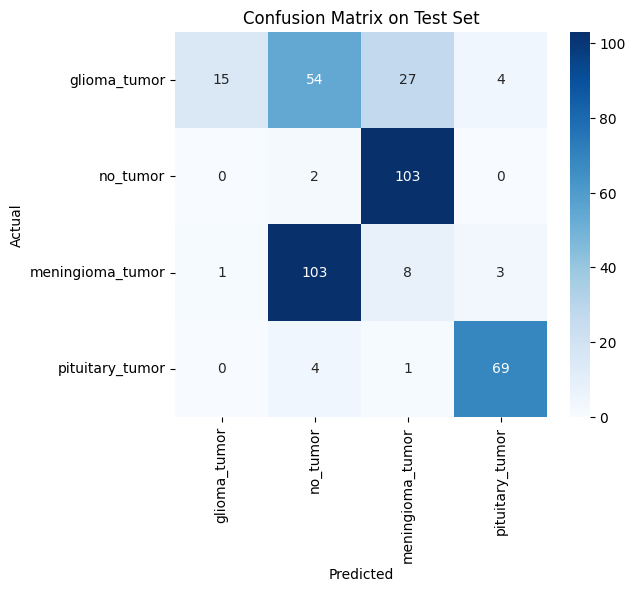

In [174]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test_one_hot, verbose=1)

print(f"\nTest Set Evaluation:")
print(f" - Loss: {test_loss:.4f}")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision: {test_precision:.4f}")
print(f" - Recall: {test_recall:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test)  
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test_one_hot, axis=1)  

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()


### Results 

- Glioma tumors are mostly misclassified as "no tumor" (54 cases).
- Meningioma tumors are also misclassified as "no tumor" (103 cases).
- Pituitary tumors are well classified, with 69 out of 74 correctly predicted

Since the model performs well on the training and validation sets but fails on the test set, the issue is likely domain shift—the test images differ in some way from the training data. Possible ways to approach it: 

-Analyze Differences Between Training and Test Images

Check if test images have different contrast, brightness, or resolution.
Compare histograms of pixel intensity distributions.

- Modify Data Augmentation to Match Test Set Better

If test images have more noise or lower contrast, introduce similar distortions in training.
Try contrast normalization or adaptive histogram equalization.


We want to again visually inspect example images to see if there is obvious reason for misclassification.

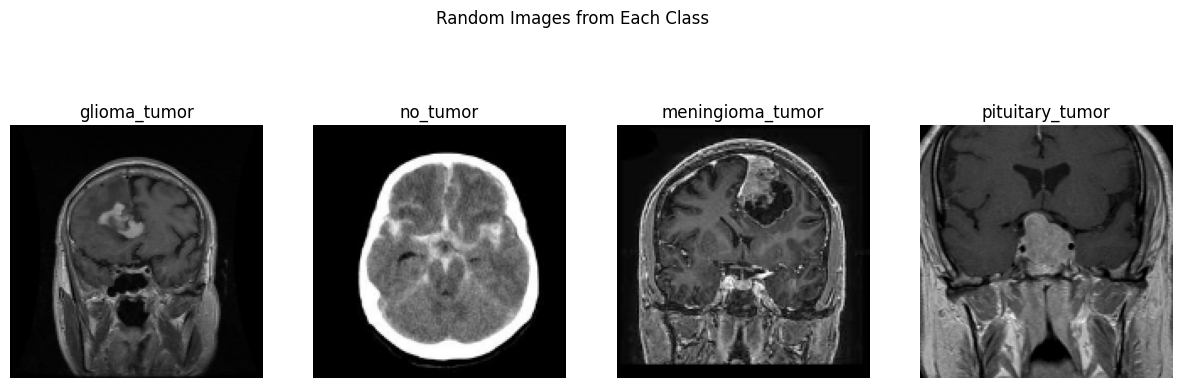

In [181]:
# Define class labels
class_labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Create a figure
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Random Images from Each Class")

# Select one random image from each class
for i, label in enumerate(class_labels):
    indices = [idx for idx, lbl in enumerate(y_test) if lbl == i]
    random_idx = random.choice(indices)
    
    axes[i].imshow(X_test[random_idx].astype("uint8"))  # Convert back to uint8 for display
    axes[i].set_title(label)
    axes[i].axis("off")

plt.show()


### Troubleshooting

#### Analyze Differences Between Training and Test Images

We compare histograms of pixel intensity distributions for each dataset to see if the test set has a different contrast or brightness distribution.

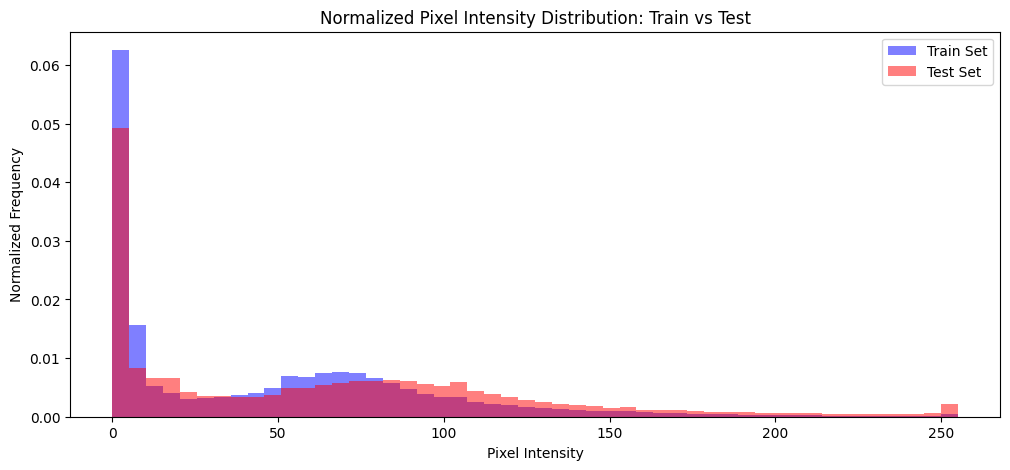

In [184]:
# Convert images to grayscale
X_train_gray = np.mean(X_train, axis=-1)
X_test_gray = np.mean(X_test, axis=-1)

# Flatten pixel values
train_pixels = X_train_gray.flatten()
test_pixels = X_test_gray.flatten()

plt.figure(figsize=(12, 5))
plt.hist(train_pixels, bins=50, alpha=0.5, color='blue', label='Train Set', density=True)
plt.hist(test_pixels, bins=50, alpha=0.5, color='red', label='Test Set', density=True)
plt.xlabel("Pixel Intensity")
plt.ylabel("Normalized Frequency")
plt.title("Normalized Pixel Intensity Distribution: Train vs Test")
plt.legend()
plt.show()


They look similar overall, except for slightly higher intensity frequencies in the test set at lower values. This suggests:

No extreme shifts in brightness or contrast, meaning the test set isn't drastically different.
The train set has a slightly higher proportion of very low-intensity pixels, which could indicate different preprocessing steps between datasets.


#### Next step: Visualize some test set misclassifications (plot original image + predicted vs actual labels).

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step


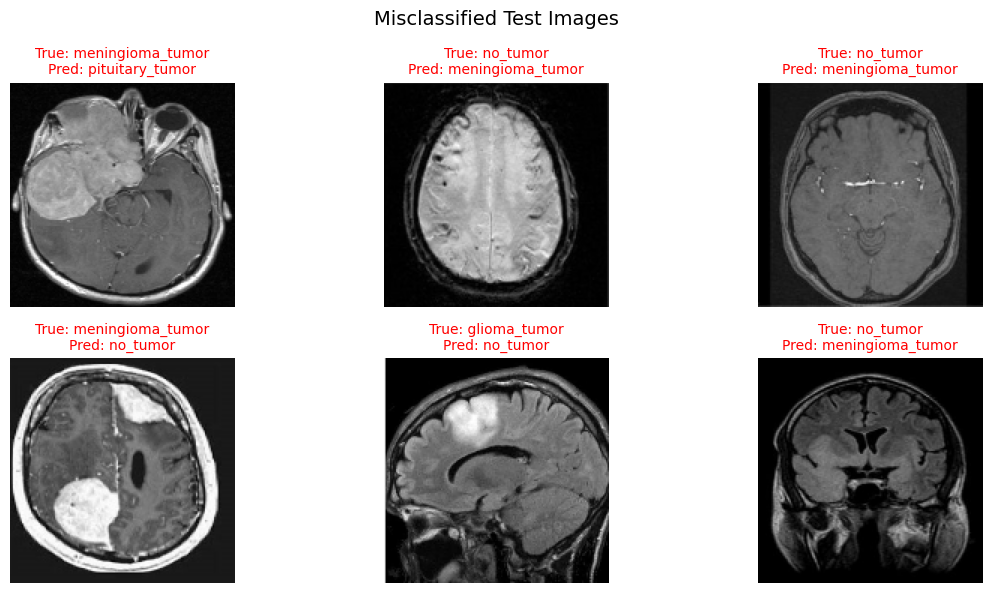

In [187]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure model is defined and X_test is properly formatted
assert 'model' in globals(), "Error: Model not found in memory."
assert isinstance(X_test, np.ndarray), "Error: X_test is not a NumPy array."
assert isinstance(y_test, np.ndarray), "Error: y_test is not a NumPy array."

# Get model predictions
y_pred = model.predict(X_test)  

# Check if predictions are correctly shaped
assert len(y_pred.shape) == 2, f"Error: Expected (num_samples, num_classes), got {y_pred.shape}"
assert y_pred.shape[0] == y_test.shape[0], "Error: Mismatch between y_pred and y_test samples."

# Convert probabilities to label indices
y_pred_labels = np.argmax(y_pred, axis=1)  

# Ensure y_test is in label form (not one-hot encoded)
if len(y_test.shape) > 1:  
    y_test_labels = np.argmax(y_test, axis=1)  
else:
    y_test_labels = y_test  

# Identify misclassified images
misclassified_indices = np.where(y_pred_labels != y_test_labels)[0]

# Ensure there are misclassified samples to display
assert len(misclassified_indices) > 0, "No misclassified samples found."

# Select a few misclassified samples to display
num_images = min(6, len(misclassified_indices))
misclassified_samples = np.random.choice(misclassified_indices, num_images, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(misclassified_samples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx].astype("uint8"), cmap="gray")  
    plt.axis("off")
    actual_label = labels[y_test_labels[idx]]
    predicted_label = labels[y_pred_labels[idx]]
    plt.title(f"True: {actual_label}\nPred: {predicted_label}", fontsize=10, color="red")

plt.suptitle("Misclassified Test Images", fontsize=14)
plt.tight_layout()
plt.show()


The model struggles mainly with meningioma, no_tumor, and glioma misclassifications. The patterns suggest:

Meningioma vs. Pituitary: Some meningiomas are classified as pituitary tumors, possibly due to similar tumor locations near the brainstem.
No Tumor vs. Meningioma: The model confuses normal brain images with meningioma cases, likely due to subtle texture differences.
Glioma vs. No Tumor: Some gliomas appear as "no tumor," possibly indicating low contrast or diffuse growth patterns.

In [190]:
test_dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing"
categories = [folder for folder in os.listdir(test_dataset_path) if not folder.startswith(".")]
print("Test dataset categories:", categories)


Test dataset categories: ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']


In [192]:
for label in categories:
    label_path = os.path.join(test_dataset_path, label)
    print(f"{label}: {len(os.listdir(label_path))} images")


no_tumor: 105 images
meningioma_tumor: 115 images
glioma_tumor: 100 images
pituitary_tumor: 74 images


In [194]:
from PIL import Image

corrupt_files = []
for label in categories:
    label_path = os.path.join(test_dataset_path, label)
    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify if it's a readable image
        except Exception as e:
            corrupt_files.append(file_path)

# Output results
if corrupt_files:
    print("Corrupt images detected:")
    for f in corrupt_files:
        print(f)
else:
    print(" No corrupt images found.")


 No corrupt images found.


In [ ]:
for label in categories:
    label_path = os.path.join(test_dataset_path, label)
    print(f"{label}: {len(os.listdir(label_path))} images")


no_tumor: 105 images
meningioma_tumor: 115 images
glioma_tumor: 100 images
pituitary_tumor: 74 images


In [195]:
from collections import Counter

print("Test Labels Distribution:", Counter(y_test))


Test Labels Distribution: Counter({2: 115, 1: 105, 0: 100, 3: 74})


In [196]:
from collections import Counter

print("Predicted Labels Distribution:", Counter(y_pred_labels))


Predicted Labels Distribution: Counter({1: 163, 2: 139, 3: 76, 0: 16})


In [198]:
# Get prediction probabilities
y_pred_prob = model.predict(X_test)

# Compute average confidence
avg_confidence = y_pred_prob.max(axis=1).mean()
print(f"Average Confidence Score: {avg_confidence:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step
Average Confidence Score: 0.8949


The model has high confidence (0.89) but is making many incorrect predictions, confirming a domain gap issue. This means the model is very sure about wrong predictions, indicating it learned features that do not generalize to the test set.

What this means:
- Not a random guessing issue (low confidence would indicate uncertainty).
- The model is misclassifying test images confidently, meaning it's overfitting to training patterns.
- Test images likely differ in some way (contrast, texture, noise, etc.).

